In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

<Axes: xlabel='time'>

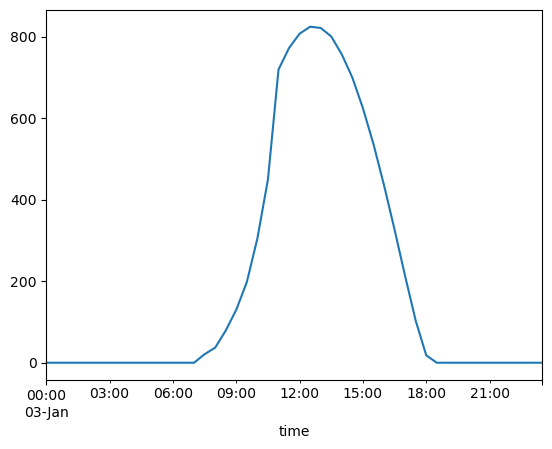

In [2]:
# Funciones trigonométricas.
def sin(x): return np.sin(np.radians(x))
def cos(x): return np.cos(np.radians(x))
def tan(x): return np.tan(np.radians(x))
def asin(x): return np.arcsin(x) * 180/np.pi
def acos(x): return np.arccos(x) * 180/np.pi
def atan(x): return np.arctan(x) * 180/np.pi

# Huso horario.
# La información está en UTC.
TZ = -6

path_f = [ f"/Users/rodrigo/Downloads/{x}/" for x in
    ["118732a9814b1cce30be83ae6846c338", "09a3146f598250e494b17fd7ab2b228e",
     "8b72b6833ba8991908023140eb48e20f", "48b30806053e210f6a72f2563343323a",
     "1b4fb35c34eadcc79bc655f23918f9ba" ] ]
name_f = "1427192_19.42_-99.15_2022.csv"
lat = 19.42
lon = -99.15
df = pd.read_csv(path_f[2] + name_f, skiprows = 2)

# Convertimos a fecha.
df["time"] = pd.to_datetime( df["Year"].astype(int).astype(str)
    + "/" + df["Month"].astype(int).astype(str) + "/"
    + df["Day"].astype(int).astype(str) + " "
    + df["Hour"].astype(int).astype(str) + ":"
    + df["Minute"].astype(int).astype(str) + ":00" )
df = df.set_index("time").drop( columns =
    ["Year", "Month", "Day", "Hour", "Minute"] )
df.loc[ (df.index.month==1) & (df.index.day==3), "GHI" ].plot()

In [3]:
# Eccentric anomaly of the earth in its orbit around the sun.
df["Day_Angle"] = 6.283185 * ( df.index.dayofyear - 1 ) / 365
# Declinación.
df["Declination"] = ( ( 0.006918 - 0.399912 * np.cos(df["Day_Angle"])
    + 0.070257*np.sin(df["Day_Angle"])
    - 0.006758*np.cos(2*df["Day_Angle"])
    + 0.000907*np.sin(2*df["Day_Angle"])
    - 0.002697*np.cos(3*df["Day_Angle"])
    + 0.00148*np.sin(3*df["Day_Angle"]) ) * 180/np.pi )
# Ecuación del tiempo.
df["Time_Equation"] = ( ( 0.000075 + 0.001868*np.cos(df["Day_Angle"])
    - 0.032077*np.sin(df["Day_Angle"])
    - 0.014615*np.cos(2*df["Day_Angle"])
    -0.040849*np.sin(2*df["Day_Angle"])) * 229.18 )
# Longitud del punto subsolar.
df["lon_subs"] = -15 * ( df.index.hour + df.index.minute/60 - TZ
    + df["Time_Equation"]/60 )
# Ángulo horario.
df["Hour_Angle"] = ( 15 * ( df.index.hour + df.index.minute/60 - 12
    - df["Time_Equation"]/60 + ((lon-TZ*15)*4)/60 ) )
#df = df.drop( columns = "Time_Equation" )
# Posiciones del analema solar.
df["Sz"] = ( sin(lat)*sin(df["Declination"])
    - cos(lat)*cos(df["Declination"])
    *cos(df["lon_subs"]-lon) )
#df = df.drop( columns = "lon_subs" )
# Ángulo del cénit solar.
df["Zenith_Angle"] = acos(df["Sz"])
#df = df.drop( columns = "Sz" )
# Ángulo acimutal solar.
df["Azimuth_Angle"] = acos( ( sin(df["Declination"])
    - cos(df["Zenith_Angle"])*sin(lat) )
    / ( sin(df["Zenith_Angle"])*cos(lat) ) )
df["Azimuth_Angle"] = df["Azimuth_Angle"].where(
    df["Hour_Angle"] < 0, 360 - df["Azimuth_Angle"] )
#df = df.drop( columns = ["Declination", "Hour_Angle"] )
# Masa de aire.
df["Air_Mass"] = ( 1/(cos(df["Zenith_Angle"])
    + 0.15/(93.885 - df["Zenith_Angle"])**1.253 )
    * df["Pressure"]/1013.25 )
df["Air_Mass"] = df["Air_Mass"].where( df["Zenith_Angle"] < 85.5, 0 )
#df = df.drop( columns = ["Day_Angle"] )

df.iloc[10:40][ ["lon_subs", "Hour_Angle",
    "GHI", "Azimuth_Angle", "Zenith_Angle"] ]

,lon_subs,Hour_Angle,GHI,Azimuth_Angle,Zenith_Angle
time,,,,,
2022-01-01 05:00:00,-164.273958,-113.423958,0,106.085111,119.686564
2022-01-01 05:30:00,-171.773958,-105.923958,0,107.568709,112.915668
2022-01-01 06:00:00,-179.273958,-98.423958,0,109.270524,106.204267
2022-01-01 06:30:00,-186.773958,-90.923958,0,111.206936,99.567114
2022-01-01 07:00:00,-194.273958,-83.423958,0,113.407272,93.022460
2022-01-01 07:30:00,-201.773958,-75.923958,40,115.914027,86.593369
2022-01-01 08:00:00,-209.273958,-68.423958,142,118.784354,80.309480
2022-01-01 08:30:00,-216.773958,-60.923958,261,122.092399,74.209404
2022-01-01 09:00:00,-224.273958,-53.423958,379,125.931904,68.343943


In [4]:
cases = [ "south_no_track", "west_no_track", "east_no_track",
    "1_track", "2_track", "bifacial_main_vertical",
    "bifacial_back_vertical", "bifacial_back_south" ]
track_tilt    =   [ f"{x}_Tilt"               for x in cases ]
track_azimuth =   [ f"{x}_Azimuth"            for x in cases ]
track_AOI     =   [ f"{x}_Angle_of_Incidence" for x in cases ]
track_POA     =   [ f"{x}_POA"                for x in cases ]
track_P_mp    = ( [ f"{x}_P_mp"               for x in cases ]
    + [ "bifacial_vertical_P_mp", "bifacial_south_P_mp" ] )
track_d_P_mp  = ( [ f"{x}_d_P_mp"             for x in cases[0:5] ]
    + [ "bifacial_vertical_d_P_mp", "bifacial_south_d_P_mp" ] )
track_net_demand    = ( [ f"{x}_net_demand"         for x in cases ]
    + [ "bifacial_vertical_net_demand", "bifacial_south_net_demand" ] )

P_bf = [ 1, 1, 1, 1, 1, 1, 0.7, 0.7 ]

azimuth_tracker = 180
tilt_tracker    = 0

df[track_azimuth[0]] = 180
df[track_tilt[0]   ] = lat
df[track_azimuth[1]] = 270
df[track_tilt[1]   ] = lat
df[track_azimuth[2]] = 90
df[track_tilt[2]   ] = lat
df[track_tilt[3]   ] = np.abs( atan( tan(df["Zenith_Angle"])
    * sin(df["Azimuth_Angle"] - azimuth_tracker) ) )
df[track_azimuth[3]] = 90
df[track_azimuth[3]] = df["1_track_Azimuth"
    ].where(df["Azimuth_Angle"]<180, 270)
df[track_tilt[4]   ] = df["Zenith_Angle"]
df[track_azimuth[4]] = df["Azimuth_Angle"]
df[track_tilt[5]   ] = 90
df[track_azimuth[5]] = 270
df[track_tilt[6]   ] = 90
df[track_azimuth[6]] = 90
df[track_tilt[7]   ] = 90 + lat
df[track_azimuth[7]] = 0

In [5]:
# Modelo de Pérez de Cielo Difuso.

# Diffuse Horizontal Radiation.
df["DHI"] = df["GHI"] - df["DNI"] * cos(df["Zenith_Angle"])
df["DHI"] = df["DHI"].where(df["DHI"]>0, 0.001)
K = 5.535e-6
# Perez clearness bins.
df["bins"] = 0
df["bins"] = df["bins"].where( df["DHI"] == 0.001,
    ( (df["DHI"]+df["DNI"])/df["DHI"] + K*df["Zenith_Angle"]**3 )
    / ( 1 + K*df["Zenith_Angle"]**3 ) )
df["DHI"] = df["DHI"].where(df["DHI"]>0.001, 0)
df["epsilon"] = df["bins"   ].where( df["bins"] < 6.200, 8 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>4.500) & (df["bins"]<6.200) ), 7 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>2.600) & (df["bins"]<4.500) ), 6 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.950) & (df["bins"]<2.600) ), 5 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.500) & (df["bins"]<1.950) ), 4 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.230) & (df["bins"]<1.500) ), 3 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.065) & (df["bins"]<1.500) ), 2 )
df["epsilon"] = df["epsilon"].where( df["bins"] > 1.065, 1 )
Perez = pd.read_csv("../code/Perez.csv", index_col = "bin" )
#df = df.drop( columns = "bins" )
# Extraterrestrial radiation.
Ea = 1367
# Coeficientes.
df["Delta"] = df["DHI"] * df["Air_Mass"] / Ea
#df = df.drop( columns = "Air_Mass" )
for j in Perez.columns:
    df[j] = 0.0
    for i in Perez.index:
        df[j] = df[j].where(df["epsilon"] != i, Perez.loc[i, j] )
#df = df.drop( columns = "epsilon" )
df["F1"] = ( df["f11"] + df["f12"]*df["Delta"]
    + np.radians(df["Zenith_Angle"])*df["f13"] )
#df = df.drop( columns = ["f11", "f12", "f13"] )
df["F1"] = df["F1"].where( df["F1"] < 0, 0 )
df["F2"] = ( df["f21"] + df["f22"]*df["Delta"]
    + np.radians(df["Zenith_Angle"])*df["f23"] )
#df = df.drop( columns = ["f21", "f22", "f23"] )
#df = df.drop( columns = ["Delta"] )
df["b"] = cos(df["Zenith_Angle"])
df["b"] = df["b"].where( df["b"] < cos(85), cos(85) )

for i in range(len(cases)):
    # Ángulo entre el panel y el sol.
    df[track_AOI[i]] = (
        cos(df["Zenith_Angle"])*cos(df[track_tilt[i]])
        + sin(df["Zenith_Angle"])*sin(df[track_tilt[i]])
        *cos(df["Azimuth_Angle"]-df[track_azimuth[i]]) )
    df[track_AOI[i]] = df[track_AOI[i]].where( df[track_AOI[i]] < 1, 1 )
    df[track_AOI[i]] = df[track_AOI[i]].where( df[track_AOI[i]] > -1, -1 )
    df[track_AOI[i]] = acos(df[track_AOI[i]])
    #df = df.drop( columns = "Azimuth_Angle" )
    df["a"] = cos(df[track_AOI[i]])
    df["a"] = df["a"].where( df["a"] < 0, 0 )
    # Radiación difusa.
    df["I_d"] = ( df["DHI"] * ( (1-df["F1"])*((1+cos(df[track_tilt[i]]))/2)
        + df["F1"]*df["a"]/df["b"] + df["F2"]*sin(df[track_tilt[i]]) ) )
    df["I_d_90"] = ( df["DHI"] * ((1+cos(df[track_tilt[i]]))/2) )
    df["I_d"] = df["I_d"].where( df["Zenith_Angle"] < 87.5, df["I_d_90"] )
    #df = df.drop( columns = "I_d_90" )
    df["I_d"] = df["I_d"].where( df["Zenith_Angle"] < 90, 0 )
    #df = df.drop( columns = ["F1", "F2", "a", "b", "DHI"] )
    #df = df.drop( columns = "Zenith_Angle" )
    # Radiación directa.
    df["I_b"] = df["DNI"] * cos(df[track_AOI[i]])
    df["I_b"] = df["I_b"].where( df[track_AOI[i]] < 90, 0 )
    #df = df.drop( columns = track_AOI[k] )
    # Radiación total en el panel.
    df[track_POA[i]] = df["I_b"] + df["I_d"]
    #df = df.drop( columns = ["I_b", "I_d"] )

print(df[track_POA].sum(axis = 0))
#df.iloc[14:38][["GHI"] + track_POA[0:3] + track_AOI[0:3]]

south_no_track_POA            4.528052e+06
west_no_track_POA             4.046565e+06
east_no_track_POA             4.321076e+06
1_track_POA                   5.248911e+06
2_track_POA                   5.570157e+06
bifacial_main_vertical_POA    1.703721e+06
bifacial_back_vertical_POA    2.137853e+06
bifacial_back_south_POA       6.134738e+05
dtype: float64


In [6]:
# NOCT Cell Temperature Model.
T_NOCT    = 44 # °C
# Datos de Panel Canadian Solar 550 W
# Modelo: HiKu6 Mono PERC CS6W-550
I_mp      = 13.2 # A
V_mp      = 41.7 # V
A_m       = 1.134*2.278 # m^2
eff_ref   = I_mp * V_mp / (1000 * A_m)
tau_alpha = 0.9
# Ajuste de viento.
#v = 0.61 # Dos pisos.
v = 0.51 # Un piso.
# Ajuste de montaje.
T_adj = 2   + T_NOCT # Building integrated,
# greater than 3.5 in, or groud/rack mounted
#T_adj = 2  + T_NOCT # 2.5 to 3.5 in
#T_adj = 6  + T_NOCT # 1.5 to 2.5 in
#T_adj = 11 + T_NOCT # 0.5 to 1.5 in
#T_adj = 18 + T_NOCT # less than 0.5 in
# Temperatura de la celda.
for i in range(len(cases)):
    df[cases[i] + "_Cell_Temperature"] = ( df["Temperature"]
        + df[track_POA[i]] / 800 * (T_adj-20)
        * (1-eff_ref/tau_alpha) * ( 9.5 / (5.7+3.8*v*df["Wind Speed"]) ) )

In [7]:
# Simple efficiency module model.
# Eficiencia por temperatura.
eff_T = -0.34
# Pérdidas del sistema.
eff_n = [ "Soiling", "Shading", "Snow", "Mismatch",
    "Wiring", "Connections", "Light_Induced_Degradation",
    "Nameplate_Rating", "Age", "Availability" ]
eff = np.array( [0.98, 0.97, 1, 0.98, 0.98,
    0.995, 0.985, 0.99, 1, 0.97] ).prod()
# Eficiencia del inversor.
eff_inv = 0.96
# Eficiencia del sistema.
eff_sys = eff_ref * eff_inv * eff
# DC to AC Size Ratio.
DC_AC = 1.1
# Inverter size.
inv_P = I_mp * V_mp / DC_AC
# Potencia generada en AC.
for i in range(len(cases)):
    df[track_P_mp[i]] = ( P_bf[i] * df[track_POA[i]]*eff_sys*A_m *
        ( 1 + eff_T/100 * (df[cases[i] + "_Cell_Temperature"]-25) ) )
    df[track_P_mp[i]] = df[ track_P_mp[i] ].where(
        df[track_P_mp[i]] < inv_P, inv_P )
    # El resultando es la generación por cada kWp.
    df[track_P_mp[i]] = df[track_P_mp[i]] * 1000 / ( I_mp * V_mp )
    df[track_P_mp[i]] = df[track_P_mp[i]].where(
        df[track_POA[i]] > 0, 0 ).where(df["GHI"] > 0, 0)
    #df = df.drop( columns = cases[i] + "_Cell_Temperature" )
    #df = ds.drop( columns = track_POA[i] )

#prod_n = track_P_mp[:5] + ["bifacial_vertical_P_mp",
#    "bifacial_south_P_mp"]

prod_n  = track_P_mp[0:5] + track_P_mp[8:]
prod_dn = track_net_demand[0:5] + track_net_demand[8:]

df[track_P_mp[8]] = df[track_P_mp[5]] + df[track_P_mp[6]]
df[track_P_mp[9]] = df[track_P_mp[0]] + df[track_P_mp[7]]
df = df.drop(columns = track_P_mp[5:8])

df[track_d_P_mp] = np.abs( 2 * ( df[prod_n] - df[prod_n].shift(1) ) )

print( df[ prod_n ].sum(axis = 0).sort_values() )

bifacial_vertical_P_mp    2.558175e+06
west_no_track_P_mp        3.130654e+06
east_no_track_P_mp        3.338641e+06
south_no_track_P_mp       3.485618e+06
bifacial_south_P_mp       3.838915e+06
1_track_P_mp              4.023053e+06
2_track_P_mp              4.244340e+06
dtype: float64


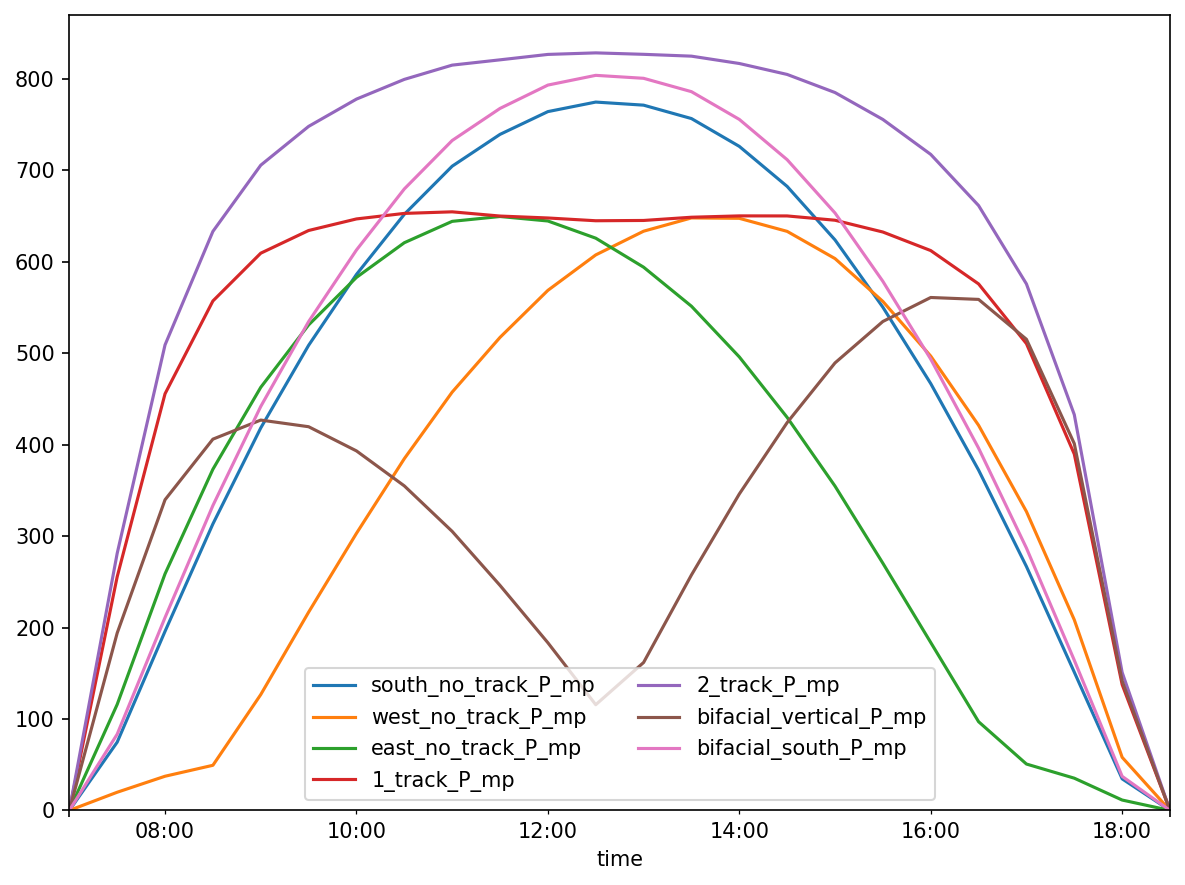

In [8]:
from matplotlib import pyplot as plt

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 6)
fig.set_dpi(150) 

df.iloc[14:38][ prod_n ].plot(ax = ax)

ax.legend(ncol = 2, loc = "lower center")
ax.set_ylim(0)

fig.tight_layout()
plt.show()

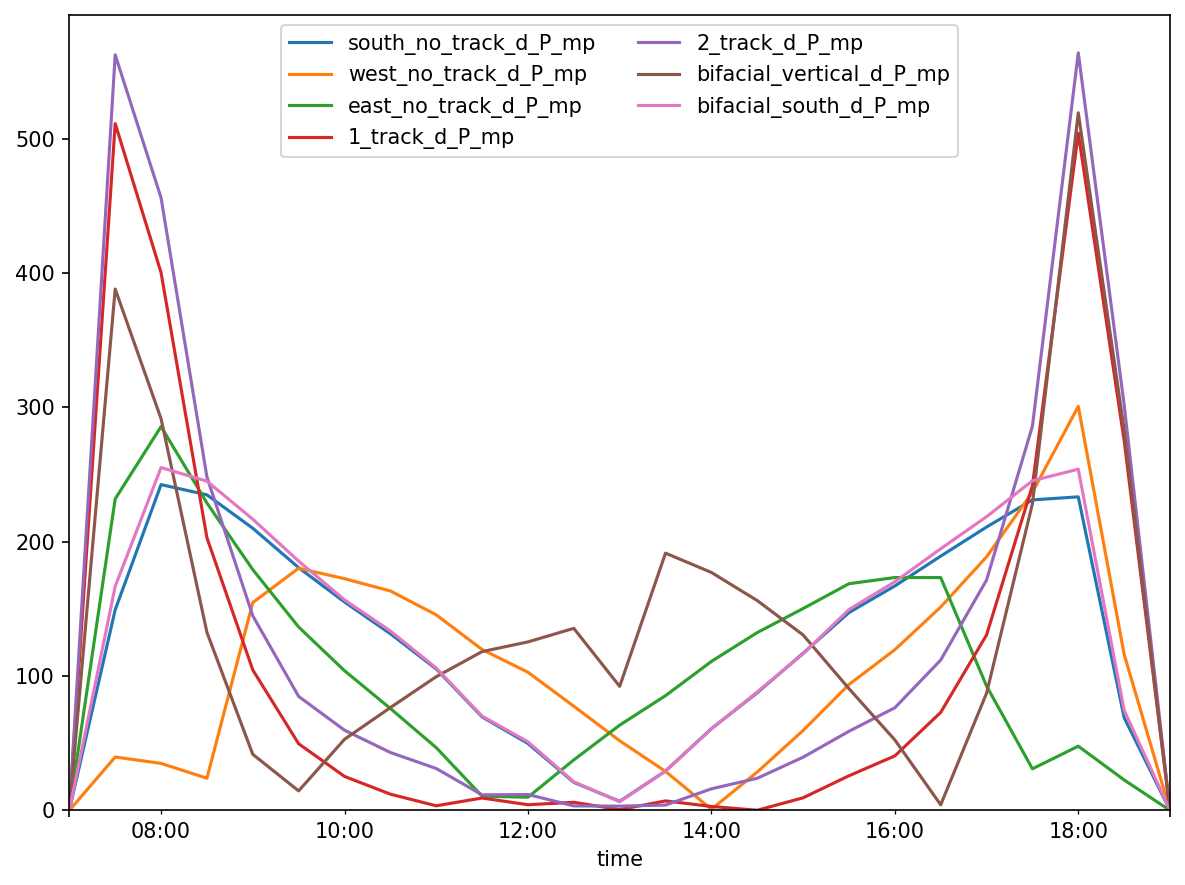

In [9]:
from matplotlib import pyplot as plt

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 6)
fig.set_dpi(150) 

df.iloc[14:39][ track_d_P_mp ].plot(ax = ax)

ax.legend(ncol = 2, loc = "upper center")
ax.set_ylim(0)

fig.tight_layout()
plt.show()

In [12]:
df["dayofyear"] = df.index.dayofyear
df["hour"] = df.index.hour + df.index.minute/60
df_clim = df[prod_n + track_d_P_mp].copy()
df_clim["hour"] = np.tile( np.arange(0, 24, 0.5), int(df.shape[0]/48))
df_clim = df_clim.groupby("hour").mean()
df_clim[prod_n].sum().sort_values()

bifacial_vertical_P_mp     7008.699775
west_no_track_P_mp         8577.134227
east_no_track_P_mp         9146.963006
south_no_track_P_mp        9549.638509
bifacial_south_P_mp       10517.574311
1_track_P_mp              11022.062856
2_track_P_mp              11628.329819
dtype: float64

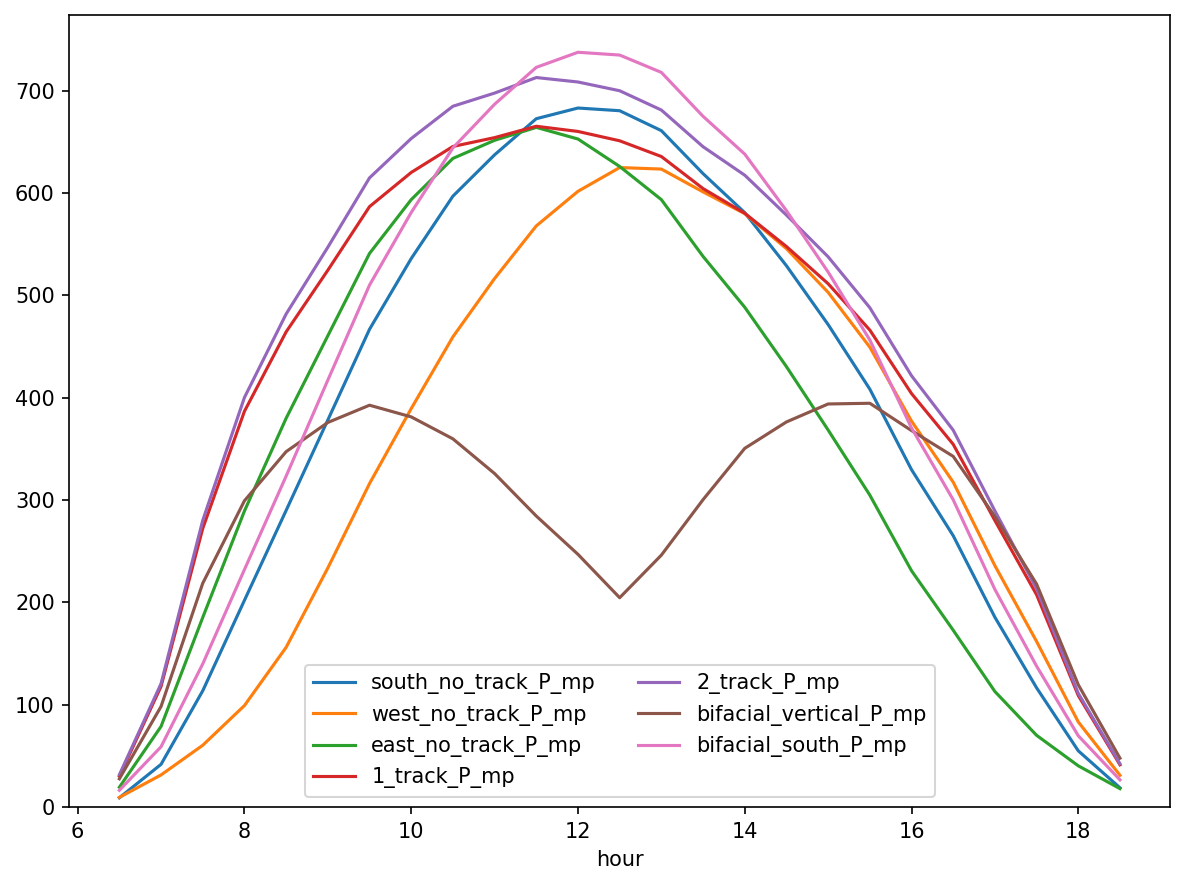

In [13]:
from matplotlib import pyplot as plt

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 6)
fig.set_dpi(150) 

df_clim.iloc[13:38][ prod_n ].plot(ax = ax)

ax.legend(ncol = 2, loc = "lower center")
ax.set_ylim(0)

fig.tight_layout()
plt.show()

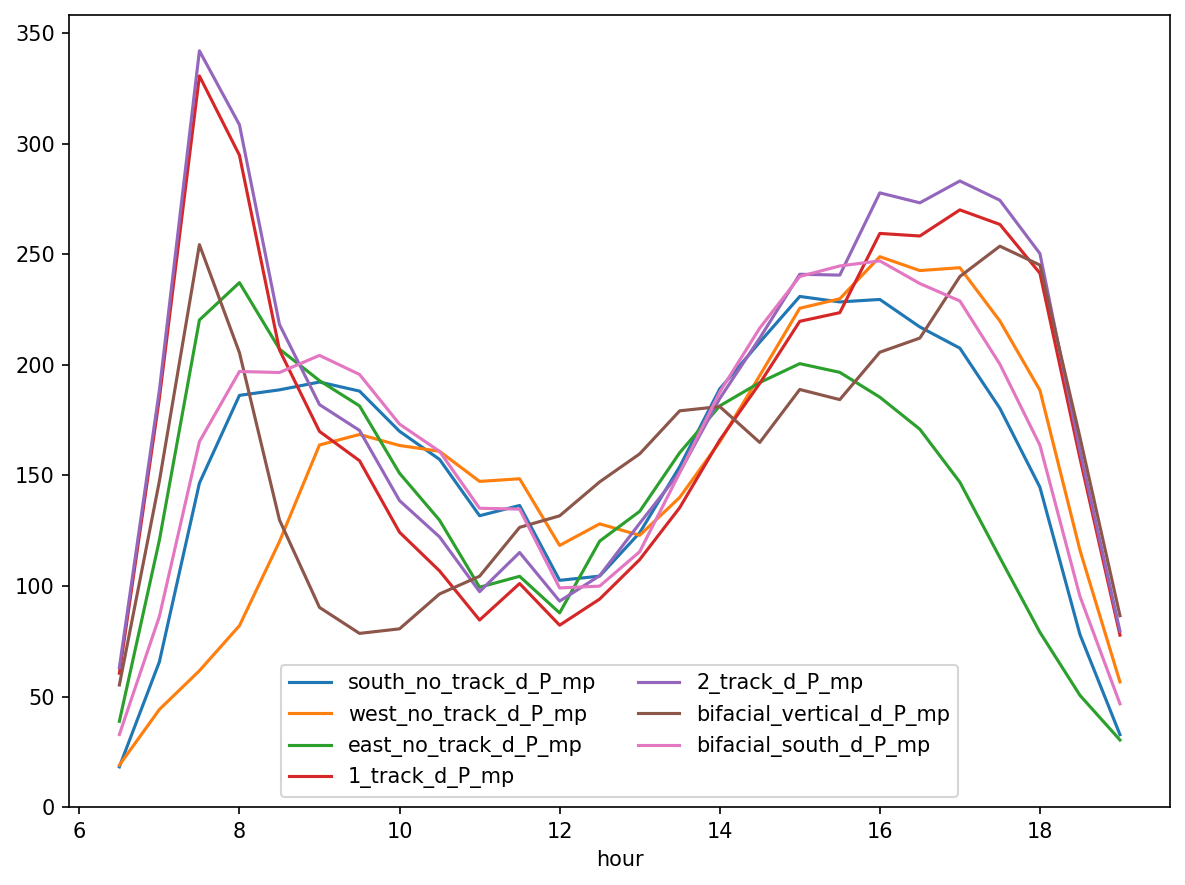

In [14]:
from matplotlib import pyplot as plt

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 6)
fig.set_dpi(150) 

df_clim.iloc[13:39][ track_d_P_mp ].plot(ax = ax)

ax.legend(ncol = 2, loc = "lower center")
ax.set_ylim(0)

fig.tight_layout()
plt.show()

In [15]:
import numpy as np
import pandas as pd
import os

path_f = "../data/Demanda/Mexico/Original/"
df_i = []
for f in os.listdir(path_f):
    if f[0] != ".":
        df_0 = pd.read_csv(path_f + f, skiprows = 8,
            na_values = "               ---" )
        df_0.columns = ['Sistema', 'Area', 'Hora', 'Generacion (MWh)',
           'Importacion Total (MWh)', 'Exportacion Total (MWh)',
            'Intercambio neto entre Gerencias (MWh)',
            'Estimacion de Demanda por Balance (MWh)']
        df_0["Hora"] = df_0["Hora"].where(df_0["Hora"] < 25, np.nan)
        df_0 = df_0.dropna()
        df_0["Hora"] = df_0["Hora"].where(df_0["Hora"] < 24, 0)

        df_0["Date"] = pd.to_datetime( df_0["Hora"].apply(
            lambda x: f"{f[40:50]} {x:02.0f}:00:00" ) )
        df_i.append( df_0.set_index("Date") )

df_1 = pd.concat(df_i).set_index( ["Sistema", "Area"],
    append = True ).sort_index()
df_1

Hora  Generacion (MWh)  \
Date                Sistema Area                           
2022-01-01 00:00:00 SIN     CEN    0.0        3072.63998   
                            NES    0.0        7624.86325   
                            NOR    0.0        3274.64940   
                            NTE    0.0        2441.51823   
                            OCC    0.0        3690.89176   
...                                ...               ...   
2022-12-31 23:00:00 SIN     NOR   23.0        3165.67037   
                            NTE   23.0        2839.76585   
                            OCC   23.0        3388.35356   
                            ORI   23.0        5345.02858   
                            PEN   23.0        1039.86279   

                                  Importacion Total (MWh)  \
Date                Sistema Area                            
2022-01-01 00:00:00 SIN     CEN                       0.0   
                            NES                       0.0   
                            NOR                       0.0   
                            NTE                       0.0   
                            OCC                       0.0   
...                                                   ...   
2022-12-31 23:00:00 SIN     NOR                       0.0   
                            NTE                       0.0   
                            OCC                       0.0   
                            ORI                       0.0   
                            PEN                       0.0   

                                  Exportacion Total (MWh)  \
Date                Sistema Area                            
2022-01-01 00:00:00 SIN     CEN                   0.00000   
                            NES                   1.00000   
                            NOR                   0.00000   
                            NTE                   0.00000   
                            OCC                   0.00000   
...                                                   ...   
2022-12-31 23:00:00 SIN     NOR                   0.00000   
                            NTE                   0.00000   
                            OCC                   0.00000   
                            ORI                  27.39608   
                            PEN                  20.55956   

                                  Intercambio neto entre Gerencias (MWh)  \
Date                Sistema Area                                           
2022-01-01 00:00:00 SIN     CEN                               2062.54700   
                            NES                              -3194.33400   
                            NOR                              -1418.11600   
                            NTE                               -144.78400   
                            OCC                               2165.36500   
...                                                                  ...   
2022-12-31 23:00:00 SIN     NOR                              -1105.41400   
                            NTE                               -426.31700   
                            OCC                               2908.22927   
                            ORI                                 -1.13700   
                            PEN                                437.47400   

                                  Estimacion de Demanda por Balance (MWh)  
Date                Sistema Area                                           
2022-01-01 00:00:00 SIN     CEN                                5135.18698  
                            NES                                4429.52925  
                            NOR                                1856.53340  
                            NTE                                2296.73423  
                            OCC                                5856.25676  
...                                                                   ...  
2022-12-31 23:00:00 SIN     NOR                                2060.

In [35]:
demanda = "Estimacion de Demanda por Balance (MWh)"
df["Demand"] = df_1.loc[ (slice(None), "SIN", "CEN"), demanda
    ].reset_index(level = [1, 2], drop = True)
df["Demand"] = df["Demand"].interpolate("cubic")

<Axes: xlabel='time'>

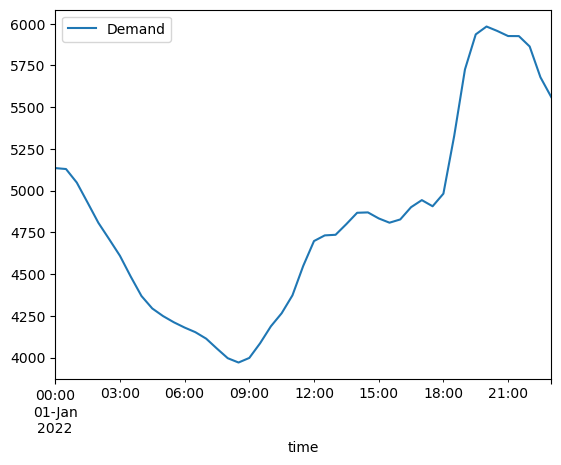

In [37]:
dia = 1
mes = 1
inicio = f"2022-{mes:02d}-{dia:02d} 00:00:00"
fin    = f"2022-{mes:02d}-{dia:02d} 23:00:00"
a = df.loc[ inicio:fin, ["Demand"]]
a.plot()
#a

In [247]:
from scipy import optimize

def demand(x, v):
    return np.nanmin(df[["Demand"]].values - df[[v]].values * x)

n = []
for v in prod_n:
    n.append( optimize.fsolve(demand, x0 = 5, args = (v))[0] )

print("Minimun capacity to reach zero net demand during duck's belly")
pd.options.display.float_format = "{:,.2f} GWp".format
a = pd.Series( n, index = prod_dn )
a.sort_values(ascending = True)

Minimun capacity to reach zero net demand during duck's belly


2_track_net_demand             5.34 GWp
bifacial_south_net_demand      5.89 GWp
south_no_track_net_demand      6.11 GWp
1_track_net_demand             6.44 GWp
east_no_track_net_demand       6.79 GWp
west_no_track_net_demand       7.41 GWp
bifacial_vertical_net_demand   8.61 GWp
dtype: float64

In [248]:
prod_dn_min = [f"{x}_min" for x in prod_dn]
prod_dn_ind = [f"{x}_ind" for x in prod_dn]
df[prod_dn_min] = (df[["Demand"]].values - df[prod_n].values * np.min(n))
df[prod_dn_ind] = (df[["Demand"]].values - df[prod_n].values * n)

print("Energy produced using individual capacity that produces zero demand")
pd.options.display.float_format = "{:,.0f} GWh".format
b = ( df[prod_n] * n / 2 ).sum()
b.sort_values(ascending = False)

Energy produced using individual capacity that produces zero demand


1_track_P_mp             12,957,578 GWh
west_no_track_P_mp       11,594,693 GWh
east_no_track_P_mp       11,330,221 GWh
2_track_P_mp             11,322,189 GWh
bifacial_south_P_mp      11,298,497 GWh
bifacial_vertical_P_mp   11,007,708 GWh
south_no_track_P_mp      10,645,703 GWh
dtype: float64

In [249]:
pd.options.display.float_format = "{:,.0f} GWh/Gwp".format
c = pd.Series( b.values / a.values, index = prod_n )
c.sort_values(ascending = False)

2_track_P_mp             2,122,170 GWh/Gwp
1_track_P_mp             2,011,526 GWh/Gwp
bifacial_south_P_mp      1,919,457 GWh/Gwp
south_no_track_P_mp      1,742,809 GWh/Gwp
east_no_track_P_mp       1,669,321 GWh/Gwp
west_no_track_P_mp       1,565,327 GWh/Gwp
bifacial_vertical_P_mp   1,279,088 GWh/Gwp
dtype: float64

In [232]:
prod_dn_min_dt = [ f"{x}_dt" for x in prod_dn_min ]
prod_dn_ind_dt = [ f"{x}_dt" for x in prod_dn_ind ]
df[prod_dn_min_dt] = ( (df[prod_dn_min] - df[prod_dn_min].shift(1)) * 2).copy()
df[prod_dn_ind_dt] = ( (df[prod_dn_ind] - df[prod_dn_ind].shift(1)) * 2).copy()

print("Ramp requirements [GW/h]")
pd.options.display.float_format = "{:,.0f}".format
np.abs( df[prod_dn_ind_dt] ).describe().drop(
    "count").T.sort_values( "max", ascending = True )

Ramp requirements [GW/h]


,mean,std,min,25%,50%,75%,max
2_track_net_demand_ind_dt,663,976,0,117,307,679,"8,405"
east_no_track_net_demand_ind_dt,636,792,0,166,388,799,"8,511"
1_track_net_demand_ind_dt,735,"1,122",0,120,312,720,"8,650"
bifacial_south_net_demand_ind_dt,623,794,0,166,391,754,"9,132"
south_no_track_net_demand_ind_dt,614,763,0,165,390,767,"9,206"
bifacial_vertical_net_demand_ind_dt,878,"1,156",0,187,460,"1,076","9,423"
west_no_track_net_demand_ind_dt,706,971,0,167,402,847,"9,825"


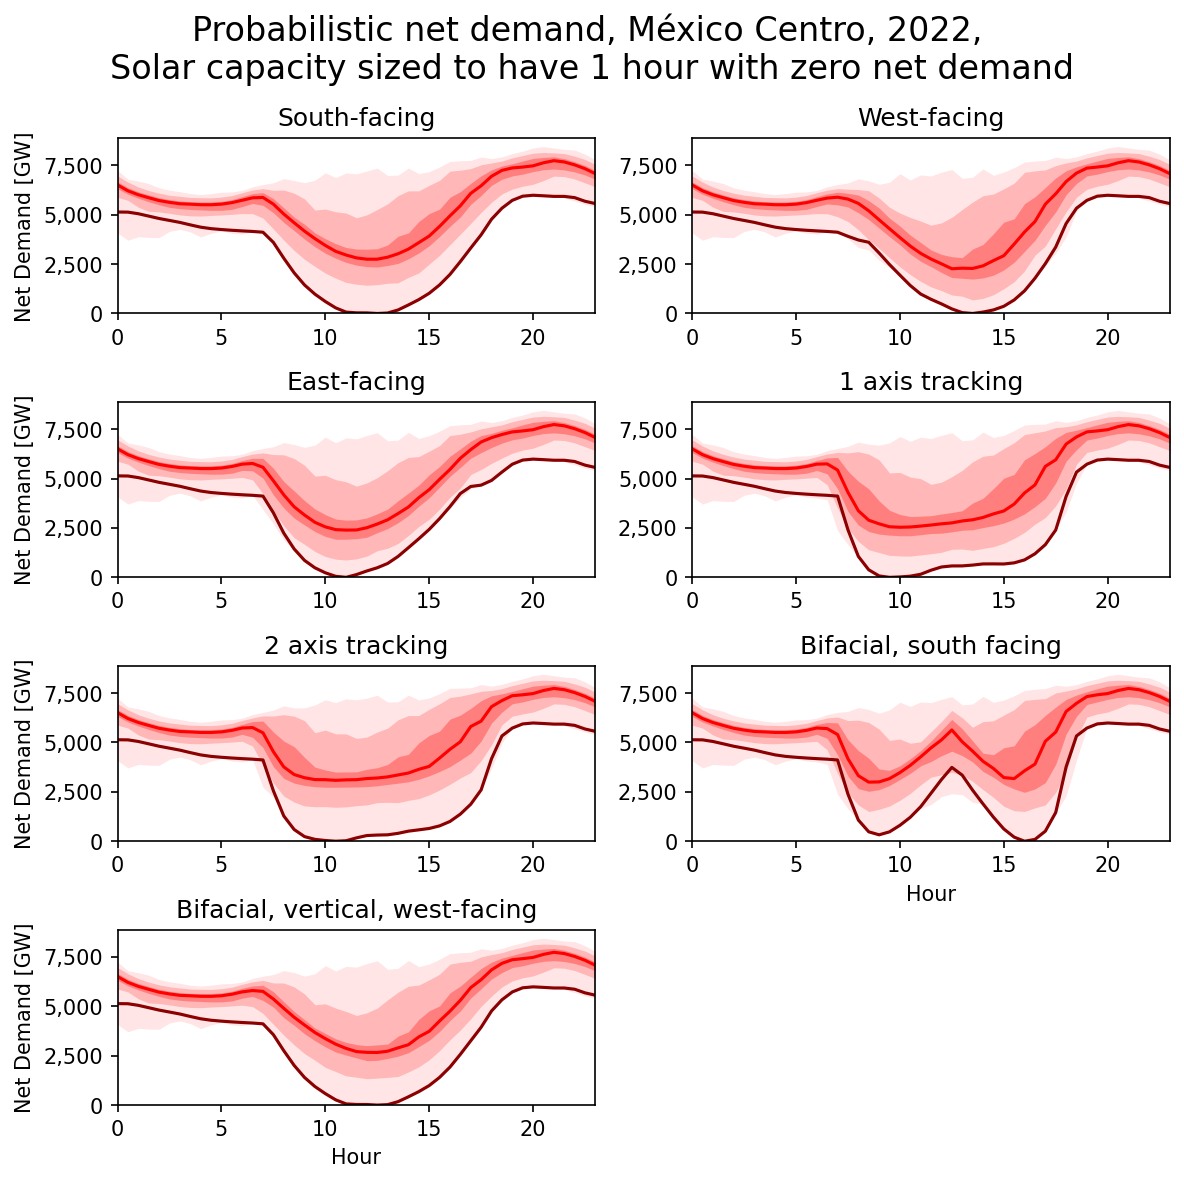

In [263]:
from matplotlib.ticker import StrMethodFormatter

i = 4

# Incializamos gráfica.
fig, axes = plt.subplots(4, 2)
fig.delaxes(axes[3,1])
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

names_dn = ["South-facing", "West-facing", "East-facing",
    "1 axis tracking", "2 axis tracking", "Bifacial, south facing",
    "Bifacial, vertical, west-facing", "Bifacial, vertical, east-facing" ]

for i, ax in enumerate(axes):
    a = df[ ["hour", "dayofyear", prod_dn_ind[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_dn_ind[i] )
    b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    ax.set_title(names_dn[i])
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Net Demand [GW]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

fig.suptitle("Probabilistic net demand, México Centro, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)

fig.tight_layout()
plt.show()